In [108]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


In [109]:
import pandas as pd
df = pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")

fraud = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0]

fraud_sample = fraud.sample(n=5000, random_state=42)
non_fraud_sample = non_fraud.sample(n=95000, random_state=42)

df_sampled = pd.concat([fraud_sample, non_fraud_sample]).sample(frac=1, random_state=42)

df_sampled.to_csv("sampled_100k_fraud.csv", index=False)


In [110]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum

spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

df_spark = spark.read.csv("sampled_100k_fraud.csv", header=True, inferSchema=True)
df_spark.show()


+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| 352|CASH_OUT| 352284.26| C350140872|     105286.0|           0.0| C902940189|           0.0|     352284.26|      0|             0|
| 522| PAYMENT|  31095.61|C1973708211|          0.0|           0.0| M559523006|           0.0|           0.0|      0|             0|
| 154|TRANSFER|3493471.66|C1418190729|          0.0|           0.0| C441171330| 1.256321668E7| 1.605668834E7|      0|             0|
| 346|CASH_OUT| 171921.18| C792702322|          0.0|           0.0|C1316273086|     371645.39|     543566.56|      0|             0|
| 332| PAYMENT|   8611.65| C117067443|      23563.0|      14951.35|M1

In [111]:
df_spark.count()          
len(df_spark.columns)      

print(f"Shape: ({df_spark.count()}, {len(df_spark.columns)})")


Shape: (100000, 11)


In [112]:
df_spark.describe().show()

+-------+-----------------+--------+-----------------+-----------+------------------+------------------+-----------+------------------+------------------+-------------------+--------------------+
|summary|             step|    type|           amount|   nameOrig|     oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|            isFraud|      isFlaggedFraud|
+-------+-----------------+--------+-----------------+-----------+------------------+------------------+-----------+------------------+------------------+-------------------+--------------------+
|  count|           100000|  100000|           100000|     100000|            100000|            100000|     100000|            100000|            100000|             100000|              100000|
|   mean|        249.80516|    NULL|247118.3893101989|       NULL| 858253.6581170999| 804929.4005236035|       NULL|1071770.1762011985|1231281.9671320955|               0.05|              1.0E-4|
| stddev|149.8299188

In [113]:
df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]).show()


+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [114]:
df_spark.groupBy("isFraud").count().orderBy("count", ascending=False).show()
#clases like this are normal in fraud detection

+-------+-----+
|isFraud|count|
+-------+-----+
|      0|95000|
|      1| 5000|
+-------+-----+



In [115]:
rename_dict = {
    "nameOrig": "origin_name",
    "oldbalanceOrg": "origin_old_balance",
    "newbalanceOrig": "origin_new_balance",
    "nameDest": "dest_name",
    "oldbalanceDest": "dest_old_balance",
    "newbalanceDest": "dest_new_balance"
}

for old_name, new_name in rename_dict.items():
    df_spark = df_spark.withColumnRenamed(old_name, new_name)


In [116]:
from pyspark.sql.functions import col, when

df_spark = df_spark.withColumn("origin_balance_change", col("origin_old_balance") - col("origin_new_balance")) \
                   .withColumn("dest_balance_change", col("dest_new_balance") - col("dest_old_balance"))
quantile = df_spark.approxQuantile("amount", [0.9], 0.01)[0]

df_spark = df_spark.withColumn("is_high_amount", (col("amount") > quantile).cast("integer"))



In [117]:
from pyspark.sql.functions import skewness

numeric_cols = [
    "amount",
    "origin_old_balance",
    "origin_new_balance",
    "dest_old_balance",
    "dest_new_balance",
    "origin_balance_change",
    "dest_balance_change",
]

for col_name in numeric_cols:
    skew_val = df_spark.select(skewness(col_name)).collect()[0][0]
    print(f"Skewness of {col_name}: {skew_val}")


Skewness of amount: 17.822927920027034
Skewness of origin_old_balance: 5.363604292562912
Skewness of origin_new_balance: 5.391980529986695
Skewness of dest_old_balance: 21.275322368857747
Skewness of dest_new_balance: 20.312465522641972
Skewness of origin_balance_change: 11.563325523975957
Skewness of dest_balance_change: 27.91670655203835


In [118]:
from pyspark.sql.functions import when, col, log1p

skewed_cols = [
    "amount",
    "origin_old_balance",
    "origin_new_balance",
    "dest_old_balance",
    "dest_new_balance",
    "origin_balance_change",
    "dest_balance_change"
]

for col_name in skewed_cols:
    df_spark = df_spark.withColumn(
        f"log_{col_name}",
        log1p(when(col(col_name) < 0, 0).otherwise(col(col_name)))
    )


In [119]:
df_spark=df_spark.drop(
    "amount",
    "origin_old_balance",
    "origin_new_balance",
    "dest_old_balance",
    "dest_new_balance",
    "origin_balance_change",
    "dest_balance_change",'dest_name','origin_name'
)

In [120]:
df_spark.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)
 |-- is_high_amount: integer (nullable = true)
 |-- log_amount: double (nullable = true)
 |-- log_origin_old_balance: double (nullable = true)
 |-- log_origin_new_balance: double (nullable = true)
 |-- log_dest_old_balance: double (nullable = true)
 |-- log_dest_new_balance: double (nullable = true)
 |-- log_origin_balance_change: double (nullable = true)
 |-- log_dest_balance_change: double (nullable = true)



In [121]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col

type_indexer = StringIndexer(inputCol="type", outputCol="type_index")

numeric_features = [
    'is_high_amount',
    'log_amount',
    'log_origin_old_balance',
    'log_origin_new_balance',
    'log_dest_old_balance',
    'log_dest_new_balance',
    'log_origin_balance_change',
    'log_dest_balance_change'
]

categorical_features = ['type_index']
numeric_assembler = VectorAssembler(inputCols=numeric_features, outputCol="numeric_features_vec")
scaler = MinMaxScaler(inputCol="numeric_features_vec", outputCol="scaled_numeric_features")
final_assembler = VectorAssembler(inputCols=["scaled_numeric_features"] + categorical_features, outputCol="features")

rf = RandomForestClassifier(featuresCol="features", labelCol="isFraud")
pipeline = Pipeline(stages=[
    type_indexer,
    numeric_assembler,
    scaler,
    final_assembler,
    rf
])
train_df, val_df, test_df = df_spark.randomSplit([0.7, 0.1, 0.2], seed=42)
model = pipeline.fit(train_df)
predictions = model.transform(test_df)


In [124]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
model = pipeline.fit(train_df)
val_predictions = model.transform(val_df)
test_predictions = model.transform(test_df)

val_auc = evaluator.evaluate(val_predictions)
print(f"AUC on Validation Set: {val_auc}")

test_auc = evaluator.evaluate(test_predictions)
print(f"AUC on Test Set: {test_auc}")


AUC on Validation Set: 0.991277882457173
AUC on Test Set: 0.9931795364337483


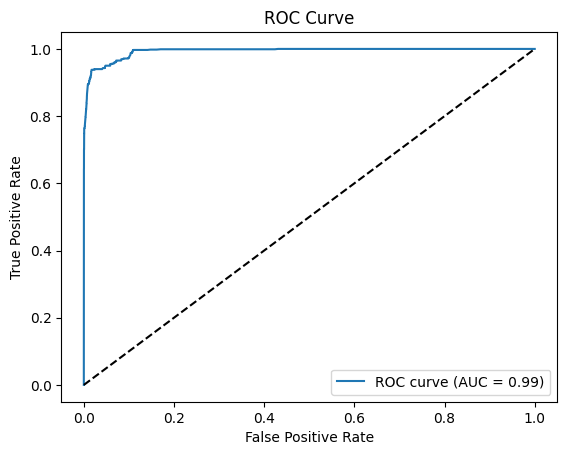

In [125]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = predictions.select("isFraud").toPandas()
y_scores = predictions.select("probability").toPandas()
y_scores = y_scores['probability'].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [126]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

get_fraud_prob = udf(lambda v: float(v[1]), DoubleType())

predictions_to_save = val_predictions \
    .withColumn("fraud_probability", get_fraud_prob("probability")) \
    .select("isFraud", "prediction", "fraud_probability")
predictions_to_save.coalesce(1).write.csv("predictions_val", header=True, mode="overwrite")
